In [1]:
import numpy as np
import oceanDAS as odas
import h5py
import h5netcdf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date, datetime, timezone

%matplotlib inline
%cd -q '/Users/hglover/Library/CloudStorage/Box-Box/FiberExperiments/DAScomparison_paper/'

# for each site: 1 channel and 1 temperature point


In [2]:
# homer
pname = 'HomerAK_Williams/'

# load water temperature and fix time to posix utc time
fname = 'ndbc46108met.csv'
f = np.genfromtxt(pname+fname, delimiter=',',skip_header=2)
f[f==99] = np.nan
wtem_hom = f[:,-1]
wtem_hom[wtem_hom>35]=np.nan
f = f.astype('int')
wtem_time_hom = np.empty(len(f))
for jj in range(len(f)):
    wtem_time_hom[jj] = datetime(f[jj,0], f[jj,1],f[jj,2], f[jj,3], f[jj,4], tzinfo=timezone.utc).timestamp()

# load strain at all channels  then pull out channel 31
fname = 'GCI_TERRA_2p5Hz_data.h5'
onechn = False
strain_hom,time_hom,chnl,depth,metadata = odas.loadHomer(pname,fname,onechn)
strain_hom = strain_hom[~np.isnan(time_hom),31]
time_hom = time_hom[~np.isnan(time_hom)]
h_hom = depth[31]

# calculate dT/dt
dT_hom = wtem_hom[1:] - wtem_hom[:-1]
dT_hom = np.hstack([dT_hom,dT_hom[-1]])*(wtem_time_hom[1]-wtem_time_hom[0])
dT_hom_cs = np.cumsum(dT_hom)

In [3]:
print(wtem_time_hom[1]-wtem_time_hom[0])
print(datetime.utcfromtimestamp(wtem_time_hom[1]))
print(datetime.utcfromtimestamp(wtem_time_hom[0]))

1800.0
2023-06-09 00:30:00
2023-06-09 00:00:00


In [4]:
# Duck
pname = 'DuckNC_Glover/'

with h5py.File(pname+'ChNo215_Nov2021fromdown.hdf5','r') as f:
    time_duc = f['Acquisition']['RawDataTime'][:] # POSIX time stamp 
    strain_duc = f['Acquisition']['RawData'][:]
f = np.genfromtxt(pname+'channelXYZ.csv', delimiter=',')
h_duc = abs(f[215,2]) # just for channel 215 ~6 m


# load temperature
fname = 'FRF-ocean_waterTempProfile_eopTemp_202111.nc'
with h5netcdf.File(pname+fname, 'r') as d:
    wtem_time_duc = d['time'][:]
    wtem_duc = d['waterTemperature'][:,-1]

wtem_duc = wtem_duc[(wtem_time_duc>time_duc[0]) & (wtem_time_duc<time_duc[-1])]
wtem_time_duc = wtem_time_duc[(wtem_time_duc>time_duc[0]) & (wtem_time_duc<time_duc[-1])]

dT_duc = wtem_duc[1:] - wtem_duc[:-1]
dT_duc = np.hstack([dT_duc,dT_duc[-1]])*(wtem_time_duc[1]-wtem_time_duc[0])

dT_duc_cs = np.cumsum(dT_duc)

In [5]:
# KNO
pname =  'KNO_Glover/'
# load rbr pressure data
with np.load(pname + 'rbr_pres_temp_ch137.npz') as data:
    wtem_time_kno = data['tvec'][:]
    wtem_kno = data['t'][:]
    h_kno = np.nanmean(data['p'])
with np.load(pname+'filtstrain_F2_ch135.npz') as data:
    time_kno=data['t']
    strain_kno = data['e']
    
dT_kno = wtem_kno[1:] - wtem_kno[:-1]
dT_kno = np.hstack([dT_kno,dT_kno[-1]])*(wtem_time_kno[1]-wtem_time_kno[0])
dT_kno_cs = np.cumsum(dT_kno)


In [6]:
# Florence
# T = datetime(BurstTime500,'ConvertFrom','datenum'); T = posixtime(T);
# A = [T(18439:2048:end),Temp500(18439:2048:end)];
# writematrix(A,'adcp500_temperature.csv','Delimiter',',')
pname = 'FlorenceOR_Ifju/'
fname = 'adcp250_temperature.csv'
f = np.genfromtxt(pname+fname, delimiter=',')
wtem_time_flo = f[:,0]
wtem_flo = f[:,1]

with np.load(pname+'mode9_0927_0930.npz') as data:
    time_flo = data['t'][::500]/1e6
    strain_flo = data['r7009'][::500]
    

dT_flo = wtem_flo[1:] - wtem_flo[:-1]
dT_flo = np.hstack([dT_flo,dT_flo[-1]])*(wtem_time_flo[1]-wtem_time_flo[0])
dT_flo_cs = np.cumsum(dT_flo)


In [11]:
# label lines by water depth
h_hom = -1
h_duc = -8
h_kno = -12
h_flo = -20

# color line by depth
x = np.linspace(0.0, 1.0, 20)
clrs = matplotlib.colormaps['winter'](x)
x = np.arange(-20,0,1)

Text(0, 0.5, 'dT/dt (C/s)')

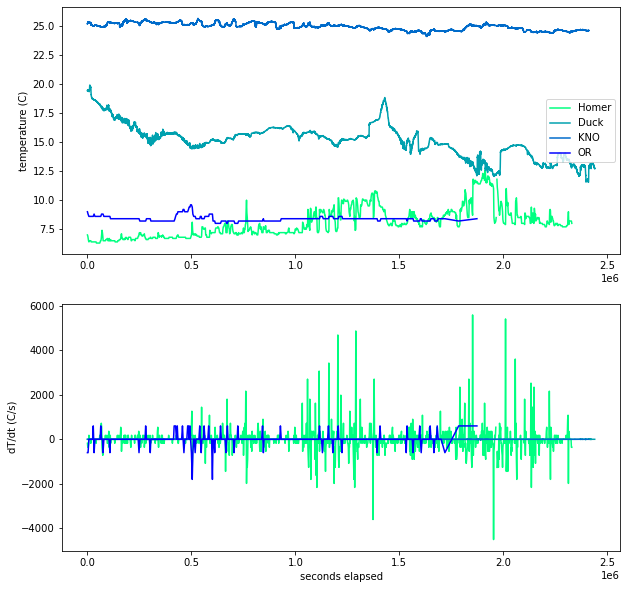

In [12]:
fig,ax = plt.subplots(2,1,figsize=(10,10))
ax[0].plot(wtem_time_hom-wtem_time_hom[0],wtem_hom,label='Homer',c = clrs[x==h_hom,:])
ax[0].plot(wtem_time_duc-wtem_time_duc[0],wtem_duc,label='Duck',c = clrs[x==h_duc,:])
ax[0].plot(wtem_time_kno-wtem_time_kno[0],wtem_kno,label='KNO',c = clrs[x==h_kno,:])
ax[0].plot(wtem_time_flo-wtem_time_flo[0],wtem_flo,label='OR',c = clrs[x==h_flo,:])
ax[0].set_ylabel('temperature (C)')
ax[0].legend(loc='center right')

ax[1].plot(wtem_time_hom-wtem_time_hom[0],dT_hom,label='Homer',c = clrs[x==h_hom,:])
ax[1].plot(wtem_time_duc-wtem_time_duc[0],dT_duc,label='Duck',c = clrs[x==h_duc,:])
ax[1].plot(wtem_time_kno-wtem_time_kno[0],dT_kno,label='KNO',c = clrs[x==h_kno,:])
ax[1].plot(wtem_time_flo-wtem_time_flo[0],dT_flo,label='OR',c = clrs[x==h_flo,:])
ax[1].set_xlabel('seconds elapsed')
ax[1].set_ylabel('dT/dt (C/s)')